# Working with the Archive Query Log in Elasticsearch
## Hands-On Session

This notebook guides you through working with the Archive Query Log (AQL) data in Elasticsearch to support your lab projects. Throughout, links to the [🔗 official ElasticSearch documentation](https://www.elastic.co/docs/reference/) are provided to help you start at the right place with your own coding.


## 1. Setting Up the Environment

Elasticsearch is a distributed search and analytics engine that allows us to efficiently query and analyze the Archive Query Log (AQL) data. The ElasticSearch cluster used in this course offers 2 separate search indices: one for SERPs (i.e. queries), and one for results (i.e., the snippets extracted from SERPs).

First, let's import the necessary libraries and connect to Elasticsearch.

In [1]:
import json
import pandas as pd
import seaborn as sns
from elasticsearch import Elasticsearch

Second, lets supply all the information necessary and connect to the Elasticsearch cluster.

**⚠️IMPORTANT**: you need to be connected to the Webis VPN to access ElasticSearch! Follow [🔗 the instructions](https://temir.org/teaching/scalable-language-technologies-ss25/vpn-instructions.html) to establish a connection after you obtained the VPN certificate from the teaching staff.

In [2]:
# Connection parameters
ES_HOST = "https://elasticsearch.bw.webis.de:9200"
ES_API_KEY = "<KEY>" # Replace with your own key
INDEX_NAME_SERPS = "aql_serps"
INDEX_NAME_RESULTS = "aql_results"

In [3]:
es = Elasticsearch(ES_HOST, api_key=ES_API_KEY, verify_certs=True, request_timeout=30)
# Test connection
try:
    es.search(index=INDEX_NAME_SERPS, body={"query": {"match_all": {}}})
    print("✅Successfully connected to Elasticsearch!")
except:
    print("❌ Connection to Elasticsearch failed.")

✅Successfully connected to Elasticsearch!


## 2. Index Mappings

A good first point to start is to explore the index mappings – they define the names and datatypes of all fields available in the index.

*Note: the info below is pasted as string, instead of retrieved from the API, as the keys distributed in the lab do not have permission to view index mappings. Execute the cell to pretty-print it.*

In [4]:
print(json.dumps(json.loads('{"aql_serps": {"mappings": {"properties": {"archive": {"properties": {"cdx_api_url": {"type": "keyword"}, "id": {"type": "keyword"}, "memento_api_url": {"type": "keyword"}, "priority": {"type": "rank_feature"}}}, "capture": {"properties": {"digest": {"type": "keyword"}, "id": {"type": "keyword"}, "mimetype": {"type": "keyword"}, "status_code": {"type": "integer"}, "timestamp": {"type": "date", "format": "strict_date_time_no_millis"}, "url": {"type": "keyword"}}}, "last_modified": {"type": "date", "format": "strict_date_time_no_millis"}, "provider": {"properties": {"domain": {"type": "keyword"}, "id": {"type": "keyword"}, "priority": {"type": "rank_feature"}, "url_path_prefix": {"type": "keyword"}}}, "url_offset": {"type": "integer"}, "url_offset_parser": {"properties": {"id": {"type": "keyword"}, "last_parsed": {"type": "date", "format": "strict_date_time_no_millis"}, "should_parse": {"type": "boolean"}}}, "url_page": {"type": "integer"}, "url_page_parser": {"properties": {"id": {"type": "keyword"}, "last_parsed": {"type": "date", "format": "strict_date_time_no_millis"}, "should_parse": {"type": "boolean"}}}, "url_query": {"type": "text"}, "url_query_parser": {"properties": {"id": {"type": "keyword"}, "last_parsed": {"type": "date", "format": "strict_date_time_no_millis"}, "should_parse": {"type": "boolean"}}}, "warc_direct_answers": {"type": "nested", "properties": {"id": {"type": "keyword"}}}, "warc_direct_answers_parser": {"properties": {"id": {"type": "keyword"}, "last_parsed": {"type": "date", "format": "strict_date_time_no_millis"}, "should_parse": {"type": "boolean"}}}, "warc_downloader": {"properties": {"id": {"type": "keyword"}, "last_downloaded": {"type": "date", "format": "strict_date_time_no_millis"}, "should_download": {"type": "boolean"}}}, "warc_location": {"properties": {"file": {"type": "keyword"}, "length": {"type": "long"}, "offset": {"type": "long"}}}, "warc_query": {"type": "text"}, "warc_query_parser": {"properties": {"id": {"type": "keyword"}, "last_parsed": {"type": "date", "format": "strict_date_time_no_millis"}, "should_parse": {"type": "boolean"}}}, "warc_snippets": {"type": "nested", "properties": {"id": {"type": "keyword"}, "rank": {"type": "integer"}}}, "warc_snippets_parser": {"properties": {"id": {"type": "keyword"}, "last_parsed": {"type": "date", "format": "strict_date_time_no_millis"}, "should_parse": {"type": "boolean"}}}}}}}'), indent=4))

{
    "aql_serps": {
        "mappings": {
            "properties": {
                "archive": {
                    "properties": {
                        "cdx_api_url": {
                            "type": "keyword"
                        },
                        "id": {
                            "type": "keyword"
                        },
                        "memento_api_url": {
                            "type": "keyword"
                        },
                        "priority": {
                            "type": "rank_feature"
                        }
                    }
                },
                "capture": {
                    "properties": {
                        "digest": {
                            "type": "keyword"
                        },
                        "id": {
                            "type": "keyword"
                        },
                        "mimetype": {
                            "type": "keyword"
        

For the SERP index, five keys (and their subfields) are of interest to us:
- `capture.*` - including information about how the URL was originally recorded in the Wayback machine, e.g., timestamp
- `provider.*` - including information about the search provider this SERP was crawled from, e.g., domain
- `url_query` - the query as parsed from the URL string
- `warc_query` - the query as parsed from the web page source (WARC is the an archive format websites are available in)
- `warc_snippets` - if available, lists the ID and rank of result snippets (not the text though!)

In [5]:
print(json.dumps(json.loads('{"aql_results": {"mappings": {"properties": {"archive": {"properties": {"cdx_api_url": {"type": "keyword"}, "id": {"type": "keyword"}, "memento_api_url": {"type": "keyword"}, "priority": {"type": "rank_feature"}}}, "capture": {"properties": {"digest": {"type": "keyword"}, "id": {"type": "keyword"}, "mimetype": {"type": "keyword"}, "status_code": {"type": "integer"}, "timestamp": {"type": "date", "format": "strict_date_time_no_millis"}, "url": {"type": "keyword"}}}, "last_modified": {"type": "date", "format": "strict_date_time_no_millis"}, "provider": {"properties": {"domain": {"type": "keyword"}, "id": {"type": "keyword"}, "priority": {"type": "rank_feature"}, "url_path_prefix": {"type": "keyword"}}}, "serp": {"properties": {"id": {"type": "keyword"}}}, "snippet": {"properties": {"content": {"type": "text"}, "id": {"type": "keyword"}, "rank": {"type": "integer"}, "text": {"type": "text"}, "title": {"type": "text"}, "url": {"type": "keyword"}}}, "snippet_parser": {"properties": {"id": {"type": "keyword"}, "last_parsed": {"type": "date", "format": "strict_date_time_no_millis"}, "should_parse": {"type": "boolean"}}}, "warc_after_serp_downloader": {"properties": {"id": {"type": "keyword"}, "last_downloaded": {"type": "date", "format": "strict_date_time_no_millis"}, "should_download": {"type": "boolean"}}}, "warc_after_serp_location": {"properties": {"file": {"type": "keyword"}, "length": {"type": "long"}, "offset": {"type": "long"}}}, "warc_before_serp_downloader": {"properties": {"id": {"type": "keyword"}, "last_downloaded": {"type": "date", "format": "strict_date_time_no_millis"}, "should_download": {"type": "boolean"}}}, "warc_before_serp_location": {"properties": {"file": {"type": "keyword"}, "length": {"type": "long"}, "offset": {"type": "long"}}}, "warc_downloader": {"properties": {"id": {"type": "keyword"}, "last_downloaded": {"type": "date", "format": "strict_date_time_no_millis"}, "should_download": {"type": "boolean"}}}, "warc_location": {"properties": {"file": {"type": "keyword"}, "length": {"type": "long"}, "offset": {"type": "long"}}}}}}}'), indent=4))

{
    "aql_results": {
        "mappings": {
            "properties": {
                "archive": {
                    "properties": {
                        "cdx_api_url": {
                            "type": "keyword"
                        },
                        "id": {
                            "type": "keyword"
                        },
                        "memento_api_url": {
                            "type": "keyword"
                        },
                        "priority": {
                            "type": "rank_feature"
                        }
                    }
                },
                "capture": {
                    "properties": {
                        "digest": {
                            "type": "keyword"
                        },
                        "id": {
                            "type": "keyword"
                        },
                        "mimetype": {
                            "type": "keyword"
      

For the result index, four keys are of interest to us:
- `capture.*` - as before, this includes Wayback information
- `provider.*` - as before, this includes search provider information
- `serp.id` - the ID of the SERP this result is part of (can be used to cross-reference with the SERP index)
- `snippet.*` - the snippet information (including ID, title, text, rank)

## 3. Querying

**Term Query**

Let's start with some simple queries to explore the AQL data. We will first do a term query on the SERP index. A *term query* returns documents that contain an exact term in a provided field. You can use the term query to find documents based on a precise value such as a provider domain.

[🔗 Elastic Documentation: Term Query](https://www.elastic.co/docs/reference/query-languages/query-dsl/query-dsl-term-query)

In [6]:
# Example 1: Simple term query to find documents for a specific provider
body = {
    "query": {
        "term": {
            "provider.domain": "google.com"  # Replace with any provider you want to search for
        }
    },
    "size": 5  # Limit to 5 results
}

response = es.search(index=INDEX_NAME_SERPS, body=body)
response

ObjectApiResponse({'took': 137, 'timed_out': False, '_shards': {'total': 40, 'successful': 40, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 10000, 'relation': 'gte'}, 'max_score': 2.6997736, 'hits': [{'_index': 'aql_serps', '_type': '_doc', '_id': '05a34173-f648-56ec-ad92-9ff17c0d7883', '_score': 2.6997736, '_source': {'last_modified': '2023-12-03T06:13:12+00:00', 'archive': {'id': 'c2135caf-2276-541a-84fa-e4ada2374aa4', 'cdx_api_url': 'https://web.archive.org/cdx/search/cdx', 'memento_api_url': 'https://web.archive.org/web', 'priority': 10.0}, 'provider': {'id': 'f205fc44-d918-4b79-9a7f-c1373a6ff9f2', 'domain': 'google.com', 'url_path_prefix': '/search?', 'priority': 1025.0}, 'capture': {'id': '05a34173-f648-56ec-ad92-9ff17c0d7883', 'url': 'https://www.google.com/search?hl=en&q=%22G.+Rodrigues%22&btnG=Google+Search&aq=f&oq=', 'timestamp': '2015-01-23T22:23:31+00:00', 'status_code': 302, 'digest': '6I37XPUIHA27GQNZMTA2HU4QAKAFXKVL', 'mimetype': 'text/html'}, 'url_query': '"G

In [7]:
pd.json_normalize(response['hits']['hits'])

,_index,_type,_id,_score,_source.last_modified,_source.archive.id,_source.archive.cdx_api_url,_source.archive.memento_api_url,_source.archive.priority,_source.provider.id,...,_source.url_query,_source.url_query_parser.id,_source.url_query_parser.should_parse,_source.url_query_parser.last_parsed,_source.url_page_parser.should_parse,_source.url_page_parser.last_parsed,_source.url_offset_parser.should_parse,_source.url_offset_parser.last_parsed,_source.warc_query_parser.should_parse,_source.warc_snippets_parser.should_parse
0,aql_serps,_doc,05a34173-f648-56ec-ad92-9ff17c0d7883,2.699774,2023-12-03T06:13:12+00:00,c2135caf-2276-541a-84fa-e4ada2374aa4,https://web.archive.org/cdx/search/cdx,https://web.archive.org/web,10.0,f205fc44-d918-4b79-9a7f-c1373a6ff9f2,...,"""G. Rodrigues""",9de961dd-8165-58ba-86d6-e63c579d7086,False,2023-12-03T06:13:12+00:00,False,2023-12-03T06:17:56+00:00,False,2023-12-03T06:18:39+00:00,True,True
1,aql_serps,_doc,8692c0c7-8917-5197-8cea-3f8488d778e4,2.699774,2023-12-03T06:28:31+00:00,c2135caf-2276-541a-84fa-e4ada2374aa4,https://web.archive.org/cdx/search/cdx,https://web.archive.org/web,10.0,f205fc44-d918-4b79-9a7f-c1373a6ff9f2,...,orderk api,9de961dd-8165-58ba-86d6-e63c579d7086,False,2023-12-03T06:28:31+00:00,False,2023-12-03T06:33:27+00:00,False,2023-12-03T06:33:44+00:00,True,True
2,aql_serps,_doc,c053b0d1-aaa5-5b3a-a196-fada5d8be84a,2.699774,2023-12-03T06:21:37+00:00,c2135caf-2276-541a-84fa-e4ada2374aa4,https://web.archive.org/cdx/search/cdx,https://web.archive.org/web,10.0,f205fc44-d918-4b79-9a7f-c1373a6ff9f2,...,medicare poll 1965,9de961dd-8165-58ba-86d6-e63c579d7086,False,2023-12-03T06:21:37+00:00,False,2023-12-03T06:33:07+00:00,False,2023-12-03T06:33:55+00:00,True,True
3,aql_serps,_doc,c75e2885-9699-5e7a-a171-cd00ecdb4899,2.699774,2023-12-03T05:53:56+00:00,c2135caf-2276-541a-84fa-e4ada2374aa4,https://web.archive.org/cdx/search/cdx,https://web.archive.org/web,10.0,f205fc44-d918-4b79-9a7f-c1373a6ff9f2,...,"£23,330 ot usd",9de961dd-8165-58ba-86d6-e63c579d7086,False,2023-12-03T05:53:56+00:00,False,2023-12-03T06:03:59+00:00,False,2023-12-03T06:03:31+00:00,True,True
4,aql_serps,_doc,c5f75228-7b9b-5639-b2e8-d90dd7a13d33,2.699774,2023-12-03T05:59:15+00:00,c2135caf-2276-541a-84fa-e4ada2374aa4,https://web.archive.org/cdx/search/cdx,https://web.archive.org/web,10.0,f205fc44-d918-4b79-9a7f-c1373a6ff9f2,...,sylas probuild,9de961dd-8165-58ba-86d6-e63c579d7086,False,2023-12-03T05:59:15+00:00,False,2023-12-03T06:03:44+00:00,False,2023-12-03T06:04:00+00:00,True,True


**Multi-Match Query**

An alternative is a *match query* – it performs relevance ranking after analyzing the query, as opposed to simple boolean term matching. The *multi-match query* is an extended form that can query multiple fields simultaneously (e.g., both `url_query` and `warc_query`).

[🔗 Elastic Documentation: Full text queries](https://www.elastic.co/docs/reference/query-languages/query-dsl/full-text-queries)

[🔗 Elastic Documentation: Multi-Match Query](https://www.elastic.co/docs/reference/query-languages/query-dsl/query-dsl-multi-match-query)



In [8]:
# Example 2: Search for queries containing specific terms
body = {
    "query": {
        "multi_match": {
            "query": "climate change",  # Replace with terms you're interested in
            "fields": ["url_query", "warc_query"]
        }
    },
    "size": 5
}

response = es.search(index=INDEX_NAME_SERPS, body=body)
pd.json_normalize(response['hits']['hits'])

,_index,_type,_id,_score,_source.last_modified,_source.archive.id,_source.archive.cdx_api_url,_source.archive.memento_api_url,_source.archive.priority,_source.provider.id,...,_source.warc_snippets_parser.last_parsed,_source.warc_location.file,_source.warc_location.offset,_source.warc_location.length,_source.warc_downloader.should_download,_source.warc_downloader.id,_source.warc_downloader.last_downloaded,_source.warc_query,_source.warc_snippets_parser.id,_source.warc_snippets
0,aql_serps,_doc,a4de3056-52bc-55cf-b405-9e5ecc209614,24.892143,2023-12-12T02:31:29+00:00,c2135caf-2276-541a-84fa-e4ada2374aa4,https://web.archive.org/cdx/search/cdx,https://web.archive.org/web,10.0,f205fc44-d918-4b79-9a7f-c1373a6ff9f2,...,2025-04-27T19:53:44+00:00,9c2897b643e740828f57e23ee9448b2c.warc.gz,649830307,7685,False,05272ece-ccde-5826-a1e2-e3b18dedefda,2025-04-03T09:29:31+00:00,climate change,NaN,NaN
1,aql_serps,_doc,1efdb715-70bd-52b5-8e12-886f57caa71a,24.753752,2023-12-12T15:24:16+00:00,c2135caf-2276-541a-84fa-e4ada2374aa4,https://web.archive.org/cdx/search/cdx,https://web.archive.org/web,10.0,f205fc44-d918-4b79-9a7f-c1373a6ff9f2,...,2025-04-02T07:03:17+00:00,f48fae250d144b79bf0f8a5b920ea830.warc.gz,660538385,45116,False,fd25893a-2de7-5e5d-af4f-72337dafc2ff,2025-04-01T14:30:52+00:00,climate change,fb283ac4-5e96-5535-8e99-1ba26ce04b8b,"[{'rank': 0, 'id': 'a17bc670-5031-5a58-95a6-71..."
2,aql_serps,_doc,1fc809c6-911e-56f3-bf07-06ffd9da275f,24.753752,2023-12-19T23:22:15+00:00,c2135caf-2276-541a-84fa-e4ada2374aa4,https://web.archive.org/cdx/search/cdx,https://web.archive.org/web,10.0,f205fc44-d918-4b79-9a7f-c1373a6ff9f2,...,2025-04-04T03:12:48+00:00,0edb21a5ebe540fd99f20909011d5b68.warc.gz,503874352,38542,False,af545384-79cd-588e-b7bf-242a21397a5e,2025-04-03T06:20:31+00:00,climate change,fb283ac4-5e96-5535-8e99-1ba26ce04b8b,"[{'rank': 0, 'id': '2b6ed49e-9ca1-53bc-a207-c0..."
3,aql_serps,_doc,c3e1d99a-30d9-5e92-8fa0-ed4a857643a7,24.753752,2023-12-13T17:46:27+00:00,c2135caf-2276-541a-84fa-e4ada2374aa4,https://web.archive.org/cdx/search/cdx,https://web.archive.org/web,10.0,f205fc44-d918-4b79-9a7f-c1373a6ff9f2,...,2025-04-04T05:34:37+00:00,a8fb148643d64ae9851ab2c00bc3938e.warc.gz,341618067,7885,False,05272ece-ccde-5826-a1e2-e3b18dedefda,2025-04-03T14:52:36+00:00,climate change,NaN,NaN
4,aql_serps,_doc,116372f7-6191-5889-9ee8-50fc8c5cbc61,24.753752,2023-12-13T16:52:10+00:00,c2135caf-2276-541a-84fa-e4ada2374aa4,https://web.archive.org/cdx/search/cdx,https://web.archive.org/web,10.0,f205fc44-d918-4b79-9a7f-c1373a6ff9f2,...,2025-04-05T07:50:29+00:00,c3409ac53159422d89f4297b3a0a94d9.warc.gz,120671951,38513,False,1eba8704-89c2-52ca-b734-a1d331b2cb5c,2025-04-04T00:04:30+00:00,climate change,fb283ac4-5e96-5535-8e99-1ba26ce04b8b,"[{'rank': 0, 'id': '40a56f51-d196-535c-85b0-f2..."


**Compound Queries**

Multiple queries can be combined to build a unified result set. For example, we can use a boolean compoung query, which wraps a multi-match query to get results on a search topic, and a term query simultaneously to get only results from a certain search provider. Results are combined like with a logical AND – both queries must match in order for a document to appear in the final result.

[🔗 Elastic Documentation: Compound Queries](https://www.elastic.co/docs/reference/query-languages/query-dsl/compound-queries)

[🔗 Elastic Documentation: Boolean Query](https://www.elastic.co/docs/reference/query-languages/query-dsl/query-dsl-bool-query)

In [9]:
# Example 3: Boolean query combining multiple conditions
body = {
    "query": {
        "bool": {
            "must": [
                {
                    "multi_match": {
                        "query": "machine learning",
                        "fields": ["url_query", "warc_query"]
                    }
                },
                {
                    "term": {
                        "provider.domain": "google.de"
                    }
                }
            ]
        }
    },
    "size": 5
}

response = es.search(index=INDEX_NAME_SERPS, body=body)
pd.json_normalize(response['hits']['hits'])

,_index,_type,_id,_score,_source.last_modified,_source.archive.id,_source.archive.cdx_api_url,_source.archive.memento_api_url,_source.archive.priority,_source.provider.id,...,_source.warc_snippets_parser.last_parsed,_source.warc_location.file,_source.warc_location.offset,_source.warc_location.length,_source.warc_downloader.should_download,_source.warc_downloader.id,_source.warc_downloader.last_downloaded,_source.warc_query,_source.warc_snippets_parser.id,_source.warc_snippets
0,aql_serps,_doc,93a6f441-47fd-5493-af4a-9fd603a603d4,29.193064,2023-12-01T21:54:30+00:00,c2135caf-2276-541a-84fa-e4ada2374aa4,https://web.archive.org/cdx/search/cdx,https://web.archive.org/web,10.0,f205fc44-d918-4b79-9a7f-c1373a6ff9f2,...,2025-04-26T00:32:28+00:00,7ed873691fb44e1d8fbe0b1a5c213b54.warc.gz,759533021,22216,False,af545384-79cd-588e-b7bf-242a21397a5e,2025-04-03T05:17:22+00:00,Machine Learning,NaN,NaN
1,aql_serps,_doc,d1d66452-005b-51f5-b102-97087d4087a3,29.189995,2024-01-23T12:21:03+00:00,c2135caf-2276-541a-84fa-e4ada2374aa4,https://web.archive.org/cdx/search/cdx,https://web.archive.org/web,10.0,f205fc44-d918-4b79-9a7f-c1373a6ff9f2,...,2025-04-06T19:27:31+00:00,933a9a99320a471696249c8df2acf2ad.warc.gz,588627420,22915,False,1eba8704-89c2-52ca-b734-a1d331b2cb5c,2025-04-03T19:45:25+00:00,Machine Learning,562deaa0-7e81-5eb0-ad98-4672a9316b18,"[{'rank': 0, 'id': 'aad84936-635c-536f-9a32-d4..."
2,aql_serps,_doc,8ab64d7f-2508-5e15-a5dd-e876f3705d61,29.189247,2023-11-30T18:14:05+00:00,c2135caf-2276-541a-84fa-e4ada2374aa4,https://web.archive.org/cdx/search/cdx,https://web.archive.org/web,10.0,f205fc44-d918-4b79-9a7f-c1373a6ff9f2,...,2025-04-26T01:20:24+00:00,84434ccb2dd54a6bb32d2a4ae4587d70.warc.gz,860672199,25856,False,05272ece-ccde-5826-a1e2-e3b18dedefda,2025-04-03T09:50:46+00:00,Machine Learning,NaN,NaN
3,aql_serps,_doc,f49fdbb0-3ed4-52ef-89a9-9488ad71bb17,29.185556,2024-01-15T06:22:59+00:00,c2135caf-2276-541a-84fa-e4ada2374aa4,https://web.archive.org/cdx/search/cdx,https://web.archive.org/web,10.0,f205fc44-d918-4b79-9a7f-c1373a6ff9f2,...,2025-04-19T18:13:25+00:00,b692795fd72a4d84a7892aaa2d254c93.warc.gz,886335064,22990,False,1eba8704-89c2-52ca-b734-a1d331b2cb5c,2025-04-15T09:41:43+00:00,Machine learning,fb283ac4-5e96-5535-8e99-1ba26ce04b8b,"[{'rank': 0, 'id': '53fb1869-c3bc-5521-ac69-49..."
4,aql_serps,_doc,e3a2f217-94b9-57eb-ba60-4d89c0e7608c,27.238749,2023-12-19T00:52:18+00:00,c2135caf-2276-541a-84fa-e4ada2374aa4,https://web.archive.org/cdx/search/cdx,https://web.archive.org/web,10.0,f205fc44-d918-4b79-9a7f-c1373a6ff9f2,...,2025-04-26T23:54:53+00:00,c51b40e2aa80453dbd792fbd2b35c748.warc.gz,136457612,23983,False,05272ece-ccde-5826-a1e2-e3b18dedefda,2025-04-03T10:48:00+00:00,Statistical Machine Learning,NaN,NaN


**Other Query Types**

Elastic offers many more specialized query types. You can find them in the [*QueryDSL section*](https://www.elastic.co/docs/reference/query-languages/querydsl) of the documentation. One handy example is the *range query*, which allows us to only get results from a certain value, e.g., time, range. Another type is the *more like this query*, which returns documents that are really similar to the example provided.

[🔗 Elastic Documentation: Range Query](https://www.elastic.co/docs/reference/query-languages/query-dsl/query-dsl-range-query)

[🔗 Elastic Documentation: More Like This Query](https://www.elastic.co/docs/reference/query-languages/query-dsl/query-dsl-mlt-query)

In [10]:
# Example 4: Time range query; only results from 2020
body = {
    "query": {
        "range": {
            "capture.timestamp": {
                "gte": "2020-01-01T00:00:00Z",
                "lte": "2021-01-01T00:00:00Z"
            }
        }
    },
    "size": 5
}

response = es.search(index=INDEX_NAME_SERPS, body=body)
pd.json_normalize(response['hits']['hits'])

,_index,_type,_id,_score,_source.last_modified,_source.archive.id,_source.archive.cdx_api_url,_source.archive.memento_api_url,_source.archive.priority,_source.provider.id,...,_source.url_query,_source.url_query_parser.id,_source.url_query_parser.should_parse,_source.url_query_parser.last_parsed,_source.url_page_parser.should_parse,_source.url_page_parser.last_parsed,_source.url_offset_parser.should_parse,_source.url_offset_parser.last_parsed,_source.warc_query_parser.should_parse,_source.warc_snippets_parser.should_parse
0,aql_serps,_doc,392670a7-2d73-5cab-b527-3fe03d4a3055,1.0,2023-11-30T18:10:04+00:00,c2135caf-2276-541a-84fa-e4ada2374aa4,https://web.archive.org/cdx/search/cdx,https://web.archive.org/web,10.0,f12d8077-5a7b-4a36-a28c-f7a3ad4f97ee,...,"""859-18-7"" OR ""Lincomycin hydrochloride"" OR ""R...",a19ba51c-5652-510b-a8d0-7ffa23093ea1,False,2023-11-30T18:10:04+00:00,False,2023-11-30T18:20:50+00:00,False,2023-11-30T18:19:51+00:00,True,True
1,aql_serps,_doc,025b3d67-07a5-579f-a144-eac70d705ce2,1.0,2023-11-30T18:13:19+00:00,c2135caf-2276-541a-84fa-e4ada2374aa4,https://web.archive.org/cdx/search/cdx,https://web.archive.org/web,10.0,f12d8077-5a7b-4a36-a28c-f7a3ad4f97ee,...,related:CUyoKZxgGVwlWM:scholar.google.com/,a19ba51c-5652-510b-a8d0-7ffa23093ea1,False,2023-11-30T18:13:19+00:00,False,2023-11-30T18:20:12+00:00,False,2023-11-30T18:18:15+00:00,True,True
2,aql_serps,_doc,9d939795-7ef3-5679-b1eb-b55d8aa25e80,1.0,2023-11-30T18:08:52+00:00,c2135caf-2276-541a-84fa-e4ada2374aa4,https://web.archive.org/cdx/search/cdx,https://web.archive.org/web,10.0,f205fc44-d918-4b79-9a7f-c1373a6ff9f2,...,"""Miles Davis"" ""MILES RUNS THE VOODOO DOWN""",9de961dd-8165-58ba-86d6-e63c579d7086,False,2023-11-30T18:08:52+00:00,False,2023-11-30T18:20:12+00:00,False,2023-11-30T18:18:09+00:00,True,True
3,aql_serps,_doc,399e07db-5464-58d8-ae08-592212794c99,1.0,2023-11-30T18:05:27+00:00,c2135caf-2276-541a-84fa-e4ada2374aa4,https://web.archive.org/cdx/search/cdx,https://web.archive.org/web,10.0,f205fc44-d918-4b79-9a7f-c1373a6ff9f2,...,rufus wainwright going to a town,9de961dd-8165-58ba-86d6-e63c579d7086,False,2023-11-30T18:05:27+00:00,False,2023-11-30T18:19:18+00:00,False,2023-11-30T18:20:38+00:00,True,True
4,aql_serps,_doc,fba08b9d-8c3e-5d11-981e-fb53c29c04b7,1.0,2023-11-30T17:59:06+00:00,c2135caf-2276-541a-84fa-e4ada2374aa4,https://web.archive.org/cdx/search/cdx,https://web.archive.org/web,10.0,f205fc44-d918-4b79-9a7f-c1373a6ff9f2,...,audioslave like a stone,9de961dd-8165-58ba-86d6-e63c579d7086,False,2023-11-30T17:59:06+00:00,False,2023-11-30T18:05:23+00:00,False,2023-11-30T18:05:39+00:00,True,True


In [11]:
# Example 5: Finding similar queries using "more like this"
seed_query = "machine learning"

mlt_query = {
    "query": {
        "more_like_this": {
            "fields": ["warc_query", "url_query"],
            "like": seed_query,
            "min_term_freq": 1,
            "min_doc_freq": 1,
            "max_query_terms": 12
        }
    },
    "size": 10
}

response = es.search(index=INDEX_NAME_SERPS, body=mlt_query)
pd.json_normalize(response['hits']['hits']).loc[:, ["_source.url_query"]]

,_source.url_query
0,windows-machine-learning+machine-learning
1,"machine learning stanford ""machine learning"""
2,machine+machine-learning
3,"machine learning stanford ""machine learning"""
4,machine-learning-model+machine-learning
5,azure-machine-learning+machine-learning
6,machine-learning+online-machine-learning
7,azure-machine-learning+machine-learning
8,"machine learning stanford ""machine learning"""
9,machine-learning+online-machine-learning


## 4. Aggregation

ElasticSearch not only allows to query data, but also perform aggregations over the result. For example, we can output a histogram of time for the results of a full-text search, for example to investigate the popularity of a query trend over time.

[🔗 Elastic Documentation: Aggregation](https://www.elastic.co/docs/reference/aggregations/)

[🔗 Elastic Documentation: Date Histogram](https://www.elastic.co/docs/reference/aggregations/search-aggregations-bucket-datehistogram-aggregation)

In [12]:
# Example: Query trends over time
body = {
    "size": 0, # We do not need the actual results, only the aggregations; don't return them to save space
    "query": {
        "multi_match": {
            "query": "covid",
            "fields": ["url_query", "warc_query"]
        }
    },
    "aggs": {
        "query_over_time": {
            "date_histogram": {
                "field": "capture.timestamp",
                "calendar_interval": "month"
            }
        }
    }
}

response = es.search(index=INDEX_NAME_SERPS, body=body)
response["aggregations"]

{'query_over_time': {'buckets': [{'key_as_string': '2020-02-01T00:00:00Z',
    'key': 1580515200000,
    'doc_count': 10},
   {'key_as_string': '2020-03-01T00:00:00Z',
    'key': 1583020800000,
    'doc_count': 1585},
   {'key_as_string': '2020-04-01T00:00:00Z',
    'key': 1585699200000,
    'doc_count': 26328},
   {'key_as_string': '2020-05-01T00:00:00Z',
    'key': 1588291200000,
    'doc_count': 3971},
   {'key_as_string': '2020-06-01T00:00:00Z',
    'key': 1590969600000,
    'doc_count': 9566},
   {'key_as_string': '2020-07-01T00:00:00Z',
    'key': 1593561600000,
    'doc_count': 6880},
   {'key_as_string': '2020-08-01T00:00:00Z',
    'key': 1596240000000,
    'doc_count': 6408},
   {'key_as_string': '2020-09-01T00:00:00Z',
    'key': 1598918400000,
    'doc_count': 5633},
   {'key_as_string': '2020-10-01T00:00:00Z',
    'key': 1601510400000,
    'doc_count': 6507},
   {'key_as_string': '2020-11-01T00:00:00Z',
    'key': 1604188800000,
    'doc_count': 7802},
   {'key_as_string': 

<Axes: xlabel='Month', ylabel='Count'>

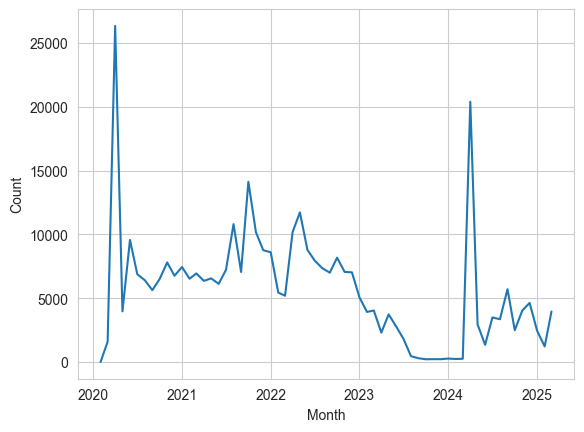

In [13]:
sns.lineplot(
    data=(
        pd.DataFrame(response["aggregations"]["query_over_time"]["buckets"])
        .assign(Month=lambda df: pd.to_datetime(df['key_as_string']))
        .rename({"doc_count": "Count"}, axis=1)
    ),
    x="Month",
    y="Count",
)

We can also aggregate the distribution of scalar term values like provider domain. Let's compare which providers occur in the two queries `covid` and `lasagna`.

[Elastic Documentation: Terms aggregation](https://www.elastic.co/docs/reference/aggregations/search-aggregations-bucket-terms-aggregation)

In [14]:
# Example: Domain distribution for query
data = []
for q in ["lasagna", "covid"]:
    body = {
        "size": 0, # We do not need the actual results, only the aggregations; don't return them to save space
        "query": {
            "multi_match": {
                "query": q,
                "fields": ["url_query", "warc_query"]
            }
        },
        "aggs": {
            "domain_counts": {
                "terms": {
                    "field": "provider.domain",  # Field containing domain names
                    "size": 20,                  # Number of top domains to return
                    "order": {
                        "_count": "desc"         # Sort by frequency (descending)
                    }
                }
            }
        }
    }
    response = es.search(index=INDEX_NAME_SERPS, body=body)
    data.append(
        pd.DataFrame(response["aggregations"]["domain_counts"]["buckets"])
        .assign(query=q)
    )

df = pd.concat(data)

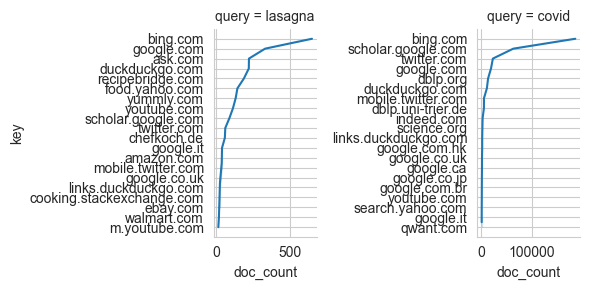

In [15]:
g = sns.FacetGrid(
    data=df,
    col="query",
    sharex=False,
    sharey=False,
)
g.map(sns.lineplot, "doc_count", "key")

## 5. Combining Results from Both Indices

Elastic can't perform merges between two indices on its own, but we can create separate queries and combine them locally in pandas. First, we find relevant SERPs, and then, we return all results (if present) from those. While creating these queries keep in mind to:
- query the results index with a SERP id, to avoid having to do separate queries for each individual snippet
- built a filter for the SERP query to restrict it to results which actually have snippets present
- built a filter for the results query to restrict it to results which actually have a text



In [16]:
# Query that includes nested snippet information
RAG_QUERY = "population of italy"
query = {
    "query": {
        "bool": {
            "must": [
                {
                    "multi_match": {
                        "query": "population of italy",
                        "fields": ["warc_query"]
                    }
                },
                {
                    "nested": {
                        "path": "warc_snippets",
                        "query": {
                            "exists": {
                                "field": "warc_snippets.id"  # Only results that have parsed results
                            }
                        }
                    }
                }
            ]
        }
    },
    "size": 100
}

serps = es.search(index=INDEX_NAME_SERPS, body=query)
serps = (
    pd.json_normalize(serps['hits']['hits'])
    .loc[:, ["_id", "_source.warc_query", "_score"]]
)
serps

,_id,_source.warc_query,_score
0,145c25fc-5885-57aa-9d63-30aac4ec3d8e,population of italy,30.888803
1,abafc38f-9885-5b21-9163-7c4bc8d1022d,population of italy,30.363157
2,ccb488f7-6e88-5a70-9817-31a588ae23ad,italy population,27.141815
3,d0b2e277-03bf-56b9-9df3-6557958053d4,italy population,26.761059
4,aa21fd08-312d-5ba5-b805-9b3b3decf704,italy population,26.761059
...,...,...,...
95,069ec9b5-eaac-54c2-a96a-ed41725b5a35,population of rockport texas,16.833158
96,69e451ab-7220-58c8-8fdc-2b8111beea25,population of launceston 2017,16.832827
97,dfe3e53b-3628-5010-aa1b-0e53af4eb002,Population Association of America,16.818312
98,31c480ff-997c-59fe-907d-6066e1ed75c2,Population of Nova Scotia,16.818312


In [17]:
# Retrieve the corresponding result texts from the result index
query = {
    "query": {
        "bool": {
            "must": [
                {
                    "terms": {
                        "serp.id": serps["_id"].values.tolist()  # Query multiple IDs at the same time for efficiency
                    },
                },
                {
                    "exists": {
                        "field": "snippet.text" # Only results that have parsed texts
                    }
                }
            ]
        }
    },
    "size": 10_000  # Set to maximum, to make sure we get all results
}
texts = es.search(index=INDEX_NAME_RESULTS, body=query)
texts = (
    pd.json_normalize(texts['hits']['hits'])
    .loc[:, ["_source.serp.id", "_source.snippet.id", "_source.snippet.text", "_source.snippet.rank"]]
)
texts

,_source.serp.id,_source.snippet.id,_source.snippet.text,_source.snippet.rank
0,332d20a1-ebe8-58ab-8a98-b492088acacf,8a923200-36ea-53e2-9684-bc137f664433,"Texas Cities by Population ; 3, Dallas, 1,300,...",11
1,d3f239f2-62a4-56e3-ae25-bbf3cb225e48,c20b9f06-78b8-5ba3-8b78-4c25e7008a1f,"made under-secretary of agriculture, later bec...",7
2,55dfccc1-3010-570b-8770-3dbf53717ad0,3ad6761d-3f42-5a06-a35a-9f4d81ca8d54,7:42,0
3,3661ebc5-51f0-55da-a500-71e7ee36a505,586812bb-a52e-5183-ba27-df86f1c8761c,[PDF],9
4,d7f1be49-ab8f-5e4e-8cf5-23b32a3ba182,508ac9b1-96a7-5d14-a32b-a33573715a43,"Americans visiting Italy, and especially Rome,...",3
...,...,...,...,...
355,e9034d8f-4561-5b77-b13e-cf5226e05458,f2b36eff-3786-59bb-af26-f72a81b69cf7,The population of New South Wales is just unde...,17
356,aca7db98-aff2-5f46-ad74-ff76e8e0ba3e,a7b4845e-7fdc-57fc-b1fe-864a47abf6ac,"Cornwall has a population of 568,210 and an ar...",8
357,e583ef25-f2f8-574d-b525-b8577b244109,fc661c39-2358-5026-a6bb-71e21c8e704c,United States. QuickFacts provides statistics ...,6
358,8146bc9c-feb0-50c6-b0d3-b03b482b30c6,a9ad89e8-a277-514c-a20a-5a99de750c7e,Em qualquer idioma,0


With both searches down, we can merge the results in pandas and built a well-structured DataFrame.

In [18]:
context = (
    pd.merge(
        serps,
        texts,
        left_on="_id",
        right_on="_source.serp.id",
        how="inner"
    )
    .drop("_id", axis=1)
    .rename({
        "_source.warc_query": "query",
        "_score": "score",
        "_source.serp.id": "serp_id",
        "_source.snippet.id": "snippet_id",
        "_source.snippet.text": "text",
        "_source.snippet.rank": "rank",
    }, axis=1)
    .sort_values(["score", "rank"], ascending=[False, True])
    .assign(length=lambda df: df["text"].apply(len)).query("length > 100") # This can also be done in Elastic directly – try to figure out how!
    .loc[:, ["query", "text"]]
    .reset_index(drop=True)
)

## 6. Putting it all together: RAG

As a final exercise, lets try to combine these snippets into a RAG answer. Let python combine all retrieved data into a prompt string that yields good results, and copy it into your favorite LLM. You can also wrap the whole pipeline into function to try out different queries.

In [19]:
RAG_PROMPT = """
You are a RAG bot. You will be a question and context in the form of search snippets. Your task is to formulate a direct response to the question using only the information provided in the context.

Question: {question}
Context:\n {context}
""".format(question=RAG_QUERY, context="\n".join(context.head(10).apply(lambda row: f"- {row[1]}", axis=1)))

print(RAG_PROMPT) # Paste into your LLM of choice and see what happens!


You are a RAG bot. You will be a question and context in the form of search snippets. Your task is to formulate a direct response to the question using only the information provided in the context.

Question: population of italy
Context:
 - The current population of Italy is 59,319,127 as of Wednesday, August 14, 2024, based on Worldometer's elaboration of the latest United Nations data1. Italy ...
- At the beginning of 2024, Italy had an estimated population of 58.9 million. Its population density, at 195.7 inhabitants per square kilometre (507/sq mi), is ...
- The population of Italy is expected to decline from 60.5 million people in 2020 to 54.4 million in 2050 and just 40.0 million in 2100.
- It is the tenth-largest country in Europe, covering an area of 301,340 km2 (116,350 sq mi), and third-most populous member state of the European Union, with a ...
- The current population of Italy in 2024 is 58,697,744, a 0.29% decline from 2023. · The population of Italy in 2023 was 58,870,7

/var/folders/54/8lplw84d1sbgcm1wmd2rgyd40000gn/T/ipykernel_90031/2410602877.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  """.format(question=RAG_QUERY, context="\n".join(context.head(10).apply(lambda row: f"- {row[1]}", axis=1)))
